In [1]:
from functions import regular, cartesian_components, sensibility_matrix, noise, random_normal_seeded, random_randint_seeded

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

import pandas as pd


microm2m = 1.0E-6
m2microm = 1.0E6

In [2]:
sensor_sample_distance = 5.0  # micrometer
area = (0, 1400*microm2m, 0, 2000*microm2m)
shape = (700,1000)
z = -sensor_sample_distance*microm2m

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A


# generates x shallow sourcers
sourcers = 100
D_1 = random_normal_seeded(45, 8, sourcers, seed_value=5)
I_1 = random_normal_seeded(45, 8, sourcers, seed_value=1)
M_1 = random_normal_seeded(20000, 5000, sourcers)
R_1 = abs( random_normal_seeded(0.5, 0.2, sourcers) )*microm2m

Xc_1 = random_randint_seeded(30, 1370, sourcers, seed_value=2)*microm2m
Yc_1 = random_randint_seeded(30, 1970, sourcers, seed_value=5)*microm2m
Zc_1 = random_randint_seeded(1, 20, sourcers, seed_value=1)*microm2m

D = D_1
I = I_1
M = M_1
R = R_1
Xc = Xc_1
Yc = Yc_1
Zc = Zc_1

# generates x deep sourcers
sourcers = 10
D_2 = random_normal_seeded(0, 180, sourcers)
I_2 = random_normal_seeded(0, 90, sourcers)
M_2 = random_normal_seeded(20000, 5000, sourcers)
R_2 = abs( random_normal_seeded(10.5, 0.1, sourcers) )*microm2m

Xc_2 = random_randint_seeded(30, 1370, sourcers)*microm2m
Yc_2 = random_randint_seeded(30, 1970, sourcers)*microm2m
Zc_2 = random_randint_seeded(500, 550, sourcers)*microm2m


# Calculate sources magnetic anomaly
m_1 = cartesian_components(D_1, I_1, M_1, R_1)
A_1 = sensibility_matrix(X, Y, Z, Xc_1, Yc_1, Zc_1)

# Calculate regional anomaly (low frequency noise)
m_2 = cartesian_components(D_2, I_2, M_2, R_2)
A_2 = sensibility_matrix(X, Y, Z, Xc_2, Yc_2, Zc_2)

In [3]:
# data vector forward model
data = A_1@m_1
regional = A_2@m_2

data = data + regional


In [4]:
#apply noise
noise_std_dev = 5.0e-9 # nT for the 'fixed method'

data = noise(data, error=noise_std_dev, method='fixed')

# Reshape data vector for the map plot
data_2D = np.reshape(data, shape)
data_2D_orig = data_2D.copy()

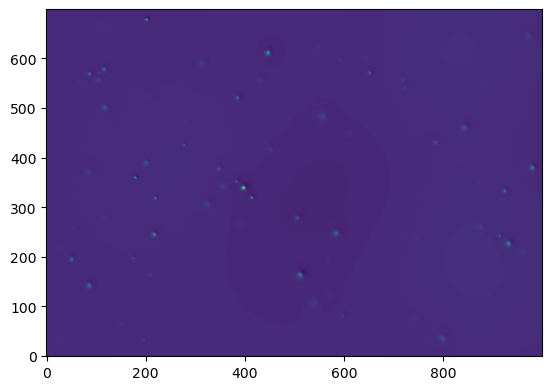

In [5]:
# show data
plt.imshow(data_2D)
plt.gca().invert_yaxis()

In [6]:
# Export synthetic data
np.savetxt("Bz_synthetic.csv", data_2D, delimiter=",")

In [7]:
# Export grid spacing
X_2D = np.reshape(X, shape)
Y_2D = np.reshape(Y, shape)
Z_2D = np.reshape(Z, shape)

nx, ny = np.shape(data_2D)
y_step = (np.max(Y_2D)*m2microm - np.min(Y_2D)*m2microm) / (ny-1)
x_step = (np.max(X_2D)*m2microm - np.min(X_2D)*m2microm) / (nx-1)

grid_spacing = pd.DataFrame(data={'x step (m)':  [x_step*microm2m],
                        'y step (m)':  [y_step*microm2m],
                        'sensor distance sample (m)': [z]
                       })


In [8]:
# Export spheres parameters
model_par = pd.DataFrame(data={'Dec (°)': D_1,
                               'Inc (°)': I_1,
                               'Mag (A/m)': M_1,
                               'Radii (µm)': R_1*m2microm,
                               'Xc (µm)': Xc_1*m2microm,
                               'Yc (µm)': Yc_1*m2microm,
                               'Zc (µm)': Zc_1*m2microm
                              })

In [9]:
grid_spacing.to_csv('grid_spacing.csv', index=False)
model_par.to_csv('model_parameters.csv', index=False)